### Generalized Addative Model for Panel Data

https://www.statsmodels.org/devel/mixed_linear.html

https://www.statsmodels.org/devel/gam.html

https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html

#### Modeling Framework 
1. Fit 3 models for each type of data 
    * GAM and / or spline model - because we have panel data 
2. Tune spline parameters 
3. Train / test split - not cross validate 
    * work on back testing modeling framework 
4. Output: 
    1. Prediction
    2. A notion of variance or uncertainty for optimization 
5. Pipeline to injest new data 

#### Querying data from SQLite

In [1]:
import sqlite3
import pandas as pd 
import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt
%matplotlib inline

db_name = '../pythonsqlite.db'

conn = sqlite3.connect(db_name)

In [2]:
query = "SELECT * FROM passing_model_data;"

df = pd.read_sql_query(query, con=conn)

In [3]:
df.head()

,Name,Week,Team,Opp,Rate,passing_fantasy_pts,lag1_fantasy_pts,lag2_fantasy_pts,avg_pts_3weeks,lag1_qbr,lag2_qbr,avg_qbr_3weeks,lag1_yds,lag2_yds,avg_yds_3weeks,lag1_fantasy_pts/avg_pts_3weeks,qbr_ratio,lag1_yds/avg_yds_3weeks
0,A.J. McCarron,17,HOU,vs TEN,65.2,8.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. McCarron,11,HOU,@ BAL,39.6,0.00,8.000,NaN,8.000,65.2,NaN,65.20,225.0,NaN,225.0,1.0,1.000000,1.000000
2,Aaron Rodgers,17,GB,@ DET,72.0,22.92,17.229,17.229,17.229,97.6,97.6,97.60,277.6,277.6,277.6,1.0,1.000000,1.000000
3,Aaron Rodgers,16,GB,@ MIN,68.3,7.64,22.920,17.229,22.920,72.0,97.6,72.00,323.0,277.6,323.0,1.0,1.000000,1.000000
4,Aaron Rodgers,15,GB,vs CHI,78.2,12.12,7.640,22.920,15.280,68.3,72.0,70.15,216.0,323.0,269.5,0.5,0.973628,0.801484


#### Data Pred & Cleaning 

In [5]:
lags = df.columns[df.columns.str.contains(pat = 'lag\d_')].tolist()
ratio = ['yds_ratio', 'rate_ratio', 'fantasy_pts_ratio']
target = ['passing_fantasy_pts']
factors = ['Name', 'Team']

In [6]:
#getting the float vars set up 
fix = lags + ratio + target

passing[fix] = passing[fix].astype(float)

In [7]:
#fixing ratios 
passing = passing.replace(np.inf, 0)

In [8]:
passing.describe()

,passing_fantasy_pts,lag3_Yds,lag3_TD,lag3_Rate,lag3_passing_fantasy_pts,lag1_Yds,lag1_TD,lag1_Rate,lag1_passing_fantasy_pts,yds_ratio,rate_ratio,fantasy_pts_ratio
count,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000
mean,13.437101,208.350510,1.309179,88.715942,13.570735,207.586151,1.283414,87.680354,13.437101,1.167203,1.085693,1.340191
std,8.420377,98.232893,0.891742,26.032002,6.947738,112.130789,1.223506,32.331005,8.420377,1.766862,0.851342,2.684893
min,-0.080000,-2.000000,0.000000,0.000000,-0.080000,-2.000000,0.000000,0.000000,-0.080000,0.000000,0.000000,0.000000
25%,7.320000,171.333333,0.666667,75.133333,10.306667,148.000000,0.000000,69.000000,7.320000,0.844215,0.880351,0.783668
50%,13.320000,229.333333,1.333333,90.433333,14.640000,220.000000,1.000000,87.900000,13.320000,1.000000,1.000000,1.000000
75%,19.120000,276.666667,2.000000,104.066667,18.213333,285.000000,2.000000,111.200000,19.120000,1.152893,1.153469,1.269663
max,37.160000,418.000000,5.000000,158.300000,32.960000,517.000000,5.000000,158.300000,37.160000,28.500000,18.731481,43.466667


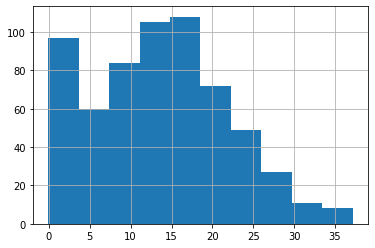

In [9]:
passing.passing_fantasy_pts.hist()
plt.show()

### Fitting GAM with Stats Models

In [10]:
#importing statsmodels packages
import statsmodels.api as sm

from statsmodels.gam.api import GLMGam, BSplines, CyclicCubicSplines

import statsmodels.formula.api as smf

In [11]:
inputs = lags + ratio

f = 'passing_fantasy_pts ~ lag3_Yds + lag3_TD + lag3_Rate + lag3_passing_fantasy_pts'\
    '+ lag1_Yds + lag1_TD + lag1_Rate + lag1_passing_fantasy_pts'\
    '+ yds_ratio + rate_ratio + fantasy_pts_ratio'

In [12]:
pass_mdl_data = passing[target + inputs]

In [15]:
#fucking OLS 
x = pass_mdl_data[inputs]
y = pass_mdl_data[target]

ols = sm.OLS(y, x)
res = ols.fit()


In [16]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     passing_fantasy_pts   R-squared (uncentered):                   1.000
Model:                             OLS   Adj. R-squared (uncentered):              1.000
Method:                  Least Squares   F-statistic:                          4.413e+31
Date:                 Mon, 02 Mar 2020   Prob (F-statistic):                        0.00
Time:                         22:12:12   Log-Likelihood:                          18717.
No. Observations:                  621   AIC:                                 -3.742e+04
Df Residuals:                      612   BIC:                                 -3.738e+04
Df Model:                            9                                                  
Covariance Type:             nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
lag3_Yds                 -8.327e-17   3.45e-17     -2.414      0.016   -1.51e-16   -1.55e-17
lag3_TD                   1.804e-16   1.18e-16      1.527      0.127   -5.16e-17    4.12e-16
lag3_Rate                -2.394e-16   6.52e-17     -3.674      0.000   -3.67e-16   -1.11e-16
lag3_passing_fantasy_pts  3.886e-16   4.71e-16      0.824      0.410   -5.37e-16    1.31e-15
lag1_Yds                     0.0024   2.56e-17   9.18e+13      0.000       0.002       0.002
lag1_TD                      0.2353   8.01e-17   2.94e+15      0.000       0.235       0.235
lag1_Rate                 1.258e-16   5.59e-17      2.252      0.025    1.61e-17    2.35e-16
lag1_passing_fantasy_pts     0.9412   3.19e-16   2.95e+15      0.000       0.941       0.941
yds_ratio                 3.886e-16   1.64e-15      0.237      0.813   -2.83e-15    3.61e-15
rate_ratio                3.678e-16   1.02e-15      0.361      0.718   -1.63e-15    2.37e-15
fantasy_pts_ratio         2.498e-16   1.08e-15      0.232      0.817   -1.87e-15    2.37e-15
==============================================================================
Omnibus:                        3.710   Durbin-Watson:                   0.238
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                3.788
Skew:                          -0.177   Prob(JB):                        0.150
Kurtosis:                       2.857   Cond. No.                     3.28e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.08e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [17]:
passing.head()

,Name,Week,Team,Opp,Score,Comp,Att,Yds,TD,Int,...,lag3_TD,lag3_Rate,lag3_passing_fantasy_pts,lag1_Yds,lag1_TD,lag1_Rate,lag1_passing_fantasy_pts,yds_ratio,rate_ratio,fantasy_pts_ratio
0,Andy Dalton,1,CIN,@ SEA,L 20-21,35.0,51.0,418.0,2.0,0.0,...,2.0,106.5,24.72,418.0,2.0,106.5,24.72,1.0,1.0,1.0
1,Dak Prescott,1,DAL,vs NYG,W 35-17,25.0,32.0,405.0,4.0,0.0,...,4.0,158.3,32.20,405.0,4.0,158.3,32.20,1.0,1.0,1.0
2,Matthew Stafford,1,DET,@ ARI,T 27-27,27.0,45.0,385.0,3.0,0.0,...,3.0,110.0,27.40,385.0,3.0,110.0,27.40,1.0,1.0,1.0
3,Case Keenum,1,WAS,@ PHI,L 27-32,30.0,44.0,380.0,3.0,0.0,...,3.0,117.6,27.20,380.0,3.0,117.6,27.20,1.0,1.0,1.0
4,Patrick Mahomes,1,KC,@ JAX,W 40-26,25.0,33.0,378.0,3.0,0.0,...,3.0,143.2,27.12,378.0,3.0,143.2,27.12,1.0,1.0,1.0


In [15]:
complexity = 3
num_vars = len(inputs)

df_iter = np.repeat(complexity, num_vars)
degrees = np.repeat(complexity - 1, num_vars)

In [16]:
x_spline = passing[inputs]

bs = BSplines(x_spline, df = df_iter, degree = degrees)

In [24]:
cs = CyclicCubicSplines(x_spline, df = df_iter)

In [25]:
pass_gam = GLMGam.from_formula(f, data = pass_mdl_data, smoother = cs, family=sm.families.Gaussian())

In [26]:
pass_results = pass_gam.fit()

PerfectSeparationError: Perfect separation detected, results not available

In [27]:
pass_mdl_data.describe()

,passing_fantasy_pts,lag3_Yds,lag3_TD,lag3_Rate,lag3_passing_fantasy_pts,lag1_Yds,lag1_TD,lag1_Rate,lag1_passing_fantasy_pts,yds_ratio,rate_ratio,fantasy_pts_ratio
count,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000
mean,13.437101,208.350510,1.309179,88.715942,13.570735,207.586151,1.283414,87.680354,13.437101,1.167203,1.085693,1.340191
std,8.420377,98.232893,0.891742,26.032002,6.947738,112.130789,1.223506,32.331005,8.420377,1.766862,0.851342,2.684893
min,-0.080000,-2.000000,0.000000,0.000000,-0.080000,-2.000000,0.000000,0.000000,-0.080000,0.000000,0.000000,0.000000
25%,7.320000,171.333333,0.666667,75.133333,10.306667,148.000000,0.000000,69.000000,7.320000,0.844215,0.880351,0.783668
50%,13.320000,229.333333,1.333333,90.433333,14.640000,220.000000,1.000000,87.900000,13.320000,1.000000,1.000000,1.000000
75%,19.120000,276.666667,2.000000,104.066667,18.213333,285.000000,2.000000,111.200000,19.120000,1.152893,1.153469,1.269663
max,37.160000,418.000000,5.000000,158.300000,32.960000,517.000000,5.000000,158.300000,37.160000,28.500000,18.731481,43.466667


In [25]:
pass_gam.

#### Using pyGAM to fit the GAM

In [ ]:
from pygam import linearnGAM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [ ]:
#tuning grid bs 
lams = np.random.rand(100, 11)
lams = lams * 11 - 3
lams = np.exp(lams)
splines = [2, 4, 6, 10, 12]
constraint_sets = ['monotonic_inc', 'concave', 'None']

In [ ]:
#setting up the data 
x = passing[inputs]
y = target

gam = LinearGAM()

gam = gam.gridsearch(x, y)